In [1]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/')
from RF_atomver import *
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, ClusterCentroids
from imblearn.ensemble import EasyEnsembleClassifier, BalancedBaggingClassifier

from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, roc_auc_score, matthews_corrcoef, balanced_accuracy_score, confusion_matrix
from sklearn.datasets import make_classification

In [2]:
samplings = ['scaled', 'UNDER', 'SMOTE', 'ADASYN']
RF_types = ['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW'] 
feat_types = ['moe', 'mfp']
neks = ['NEK2_binding', 'NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']

In [7]:
nek_order = ['NEK2_binding (4.24%)','NEK9_binding (4.59%)','NEK3_binding (6.03%)','NEK2_inhibition (6.85%)','NEK5_binding (8.06%)','NEK9_inhibition (11.25%)' ]

strategy_order3 = list(special_palette3.keys())
# style='modeling_type',markers=rf_type_dict
model_types_dict = {'RF': 'p', 'GP_matern':'^' }
markers3 = {'RF': 'o', 'RF_BCW': '*', 'BRFC':'s', 'BRFC_BCW': 'p', 'GP_matern':'v'}
rf_type_dict ={'RF': '^', 'RF_GS': 's'} 

special_palette = sns.color_palette("cubehelix", n_colors=6)
# array(['raw_RF', 'raw_RF_BCW', 'raw_BRFC', 'raw_BRFC_BCW', 'UNDER_RF',
#        'ADASYN_RF'], dtype=object)

special_palette = {'raw_RF': '#8C5383', 'raw_RF_BCW': '#92374D', 
                   'raw_BRFC': '#9CD08F', 'raw_BRFC_BCW': '#35605A', 
                   'UNDER_RF': '#42BFDD', 'ADASYN_RF': '#A3CEF1'}

special_palette2 = {'raw_RF': 'tab:red', 'raw_RF_BCW': 'purple', 
                   'raw_BRFC': 'limegreen', 'raw_BRFC_BCW': '#35605A', 
                   'UNDER_RF': '#42BFDD', 'ADASYN_RF': 'yellow'}
special_palette3 = {'raw_RF': 'tab:red', 'raw_RF_BCW': 'purple', 
                   'raw_BRFC': 'limegreen', 'raw_BRFC_BCW': '#35605A', 
                   'UNDER_RF': '#42BFDD', 'ADASYN_RF': 'yellow', 
                   'raw_GP':'tab:red', 'UNDER_GP':'#42BFDD', 'ADASYN_GP':'yellow' }
                   
this_palette = {'raw': 'tab:blue', 'UNDER': 'tab:orange', 'ADASYN': 'tab:red'}

In [13]:
samp_markers = {'raw': 'o', 'UNDER': 'd', 'SMOTE': '>', 'ADASYN': '<'}
shapes = ['*', 'd', 'v', '.', 'o', '^'] 
palette = sns.color_palette("Set2")
nek_colors = {'NEK2_binding (4.24%)':palette[0], 'NEK2_inhibition (6.85%)': palette[1],
       'NEK3_binding (6.03%)': palette[2], 'NEK5_binding (8.06%)': palette[3],
       'NEK9_binding (4.59%)': palette[4], 'NEK9_inhibition (11.25%)' : palette[5]}


nek_markers = {'NEK2_binding (4.24%)':'*', 'NEK2_inhibition (6.85%)': 'd',
       'NEK3_binding (6.03%)': 'v', 'NEK5_binding (8.06%)': 'X',
       'NEK9_binding (4.59%)': 'o', 'NEK9_inhibition (11.25%)' : '^'}

In [4]:
# ratio_df = pd.read_excel('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/dataset_creation/NEK_condensed_sizes.xlsx')
# nek_ratios = {}
# raw_dfs = ratio_df[ratio_df['strategy']=='raw']
# for k, val in enumerate(raw_dfs['NEK']): 
#     nek_ratios[val] =list(raw_dfs['active%_test'])[k]
# for k, val in nek_ratios.items(): 
#     this_val = f"{val:.2f}"
#     new_val = k+' ('+this_val+'%)'
#     nek_ratios[k] = new_val
nek_ratios = {'NEK2_binding':'NEK2_binding (4.24%)', 'NEK9_binding':'NEK9_binding (4.59%)' ,'NEK3_binding': 'NEK3_binding (6.03%)',
             'NEK2_inhibition':'NEK2_inhibition (6.85%)','NEK5_binding':'NEK5_binding (8.06%)','NEK9_inhibition':'NEK9_inhibition (11.25%)' } 
# redo bc of nek2 inhib duplicates 

# pairing down models/datasetes

In [11]:
df = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/general_NEK/GP_GPmatern_RF_RFGS_results_all_sets.csv')
df = df[(df['set'] !='literature') & (df['modeling_type']!='RF_GS')]

df = df[(df['strategy'] != 'SMOTE') & (df['set'] !='literature')]
rf= df[df['modeling_type'] != 'GP']
rf= rf[rf['modeling_type'] != 'GP_matern']

rf['modeling_type'].unique()
rf_raw = rf[(rf['strategy'] == 'raw') & (rf['RF_type'].isin(['RF', 'RF_BCW', 'BRFC', 'BRFC_BCW']))]
rf_other = rf[(rf['RF_type'] == 'RF') & (rf['strategy'].isin(['UNDER', 'ADASYN']))]  
rf_filtered = pd.concat([rf_raw, rf_other])
total_rf = rf_filtered.copy() 
total_rf['strategy'] =total_rf['strategy'].astype(str) +'_'+ total_rf['RF_type']

total_rf['modeling_type'] ='RF'

gp= df[df['modeling_type'] == 'GP_matern']
gp['strategy'] = gp['strategy'].astype(str)+'_GP'

full_df = pd.concat([gp, total_rf]) 
full_df['1-specificity'] = 1-full_df['specificity']

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_66190/2743923972.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gp['strategy'] = gp['strategy'].astype(str)+'_GP'


# all results moe vs mfp

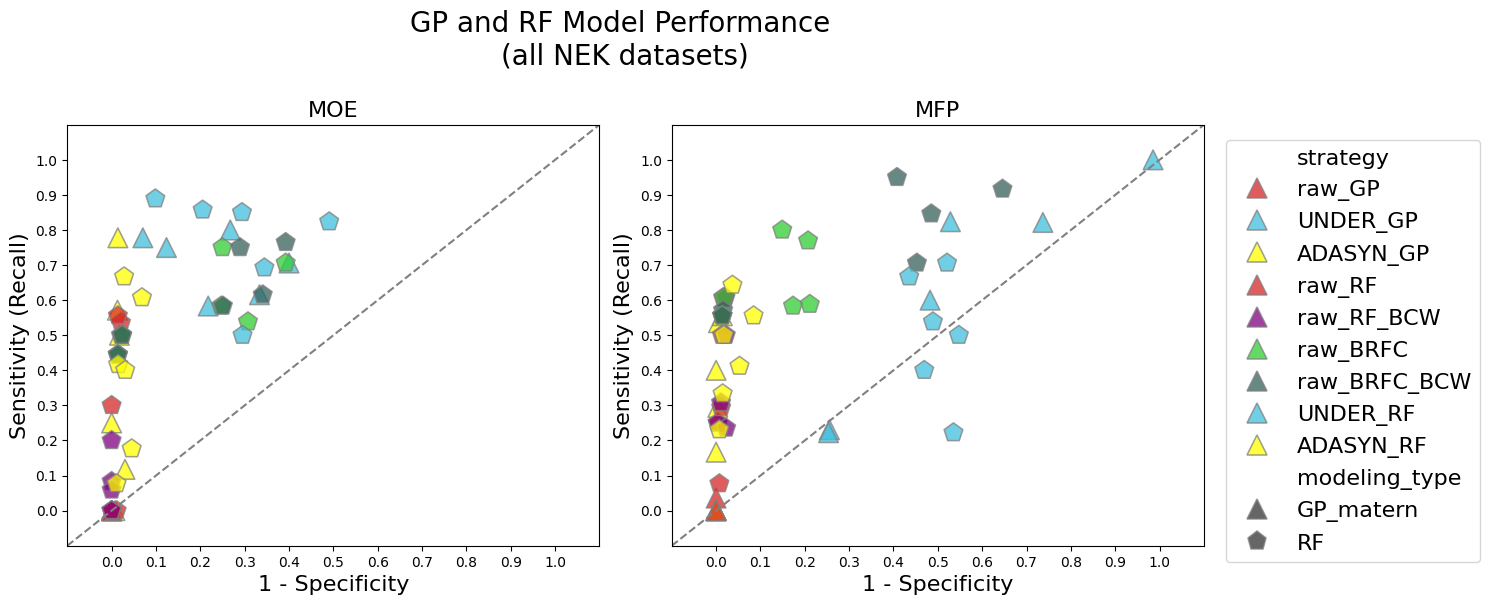

In [32]:

fig, axs = plt.subplots(1,2, figsize=(15,6))

moe_df =full_df[full_df['feat_type'] == 'moe']
mfp_df = full_df[full_df['feat_type'] == 'mfp']

sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
               alpha=0.75, palette=special_palette3,s=200, edgecolor='gray', ax=axs[0])
sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
               alpha=0.75, palette=special_palette3,s=200,legend=True, ax=axs[1],edgecolor='gray')

plt.suptitle(f'GP and RF Model Performance \n(all NEK datasets)', fontsize=20, x=0.42, y =1.0005)

plt.legend(bbox_to_anchor = [.2, 0.9])
for i in range(len(axs)): 
    
    axs[i].plot([-0.1, 1.1],[-0.1,1.1], linestyle='--', color='gray')
    axs[i].get_legend().remove()
    axs[i].set_xlabel('1 - Specificity', fontsize=16)
    axs[i].set_ylabel('Sensitivity (Recall)', fontsize=16)
    axs[i].set_xlim(-0.1, 1.1)
    axs[i].set_ylim(-0.1, 1.1)
    axs[i].set_xticks(np.arange(0, 1.1, 0.1))
    axs[i].set_yticks(np.arange(0, 1.1, 0.1))
    if (i==0): 
        this_title='MOE'
    else: 
        this_title='MFP' 
    

    axs[i].set_title(f'{this_title}', fontsize=16)


axs[1].legend(ncols=1, bbox_to_anchor=(1.02, 0.99),fontsize=16)
plt.tight_layout();
plt.savefig(f'{figure_path}all_NEK/RF_and_GP.png', bbox_inches='tight')

plt.show();


In [15]:
full_df['NEK'].value_counts()
full_df['regular NEK'] = full_df['NEK'].str.split(' ').str[0]
full_df['regular NEK'].value_counts()
full_df['dataset type'] = ['binding' if nek in ['NEK2_binding','NEK3_binding','NEK5_binding','NEK9_binding'] else 'inhibition' for nek in full_df['regular NEK']]
full_df['dataset type'].value_counts()

dataset type
binding       72
inhibition    36
Name: count, dtype: int64

# Binding and Inhibition separate (and separated by moe mfp)

In [16]:
bind_df = full_df[full_df['dataset type'] == 'binding'] 
inhib_df =full_df[full_df['dataset type'] == 'inhibition'] 

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_66190/1105375136.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor = [.2, 0.9])


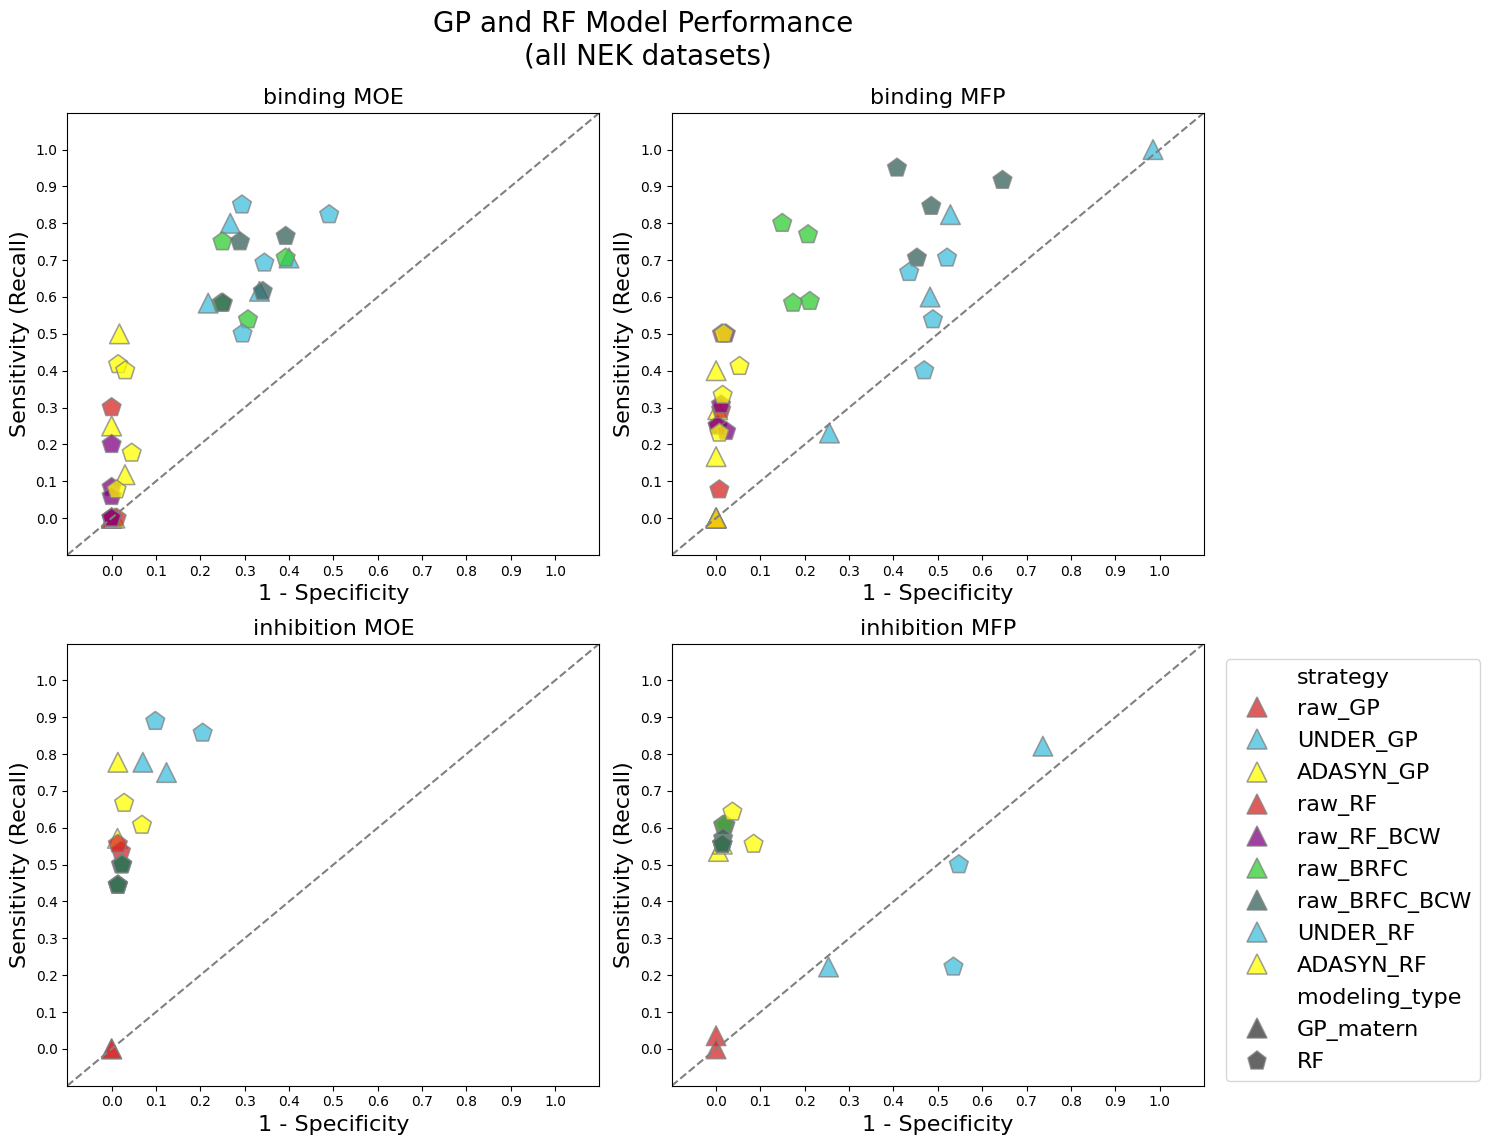

In [18]:
figure_path = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/plots/best_models/sensitivity_1_specificity/all_NEK/'
fig, axs = plt.subplots(2,2, figsize=(15,12))
for i, this_df in enumerate(list([bind_df, inhib_df])): 
    moe_df =this_df[this_df['feat_type'] == 'moe']
    mfp_df = this_df[this_df['feat_type'] == 'mfp']
    
    sns.scatterplot(data=moe_df, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
                   alpha=0.75, palette=special_palette3,s=200, edgecolor='gray', ax=axs[i,0])
    sns.scatterplot(data=mfp_df, x='1-specificity', y='recall', hue='strategy',style='modeling_type', markers=model_types_dict,
                   alpha=0.75, palette=special_palette3,s=200,legend=True, ax=axs[i,1],edgecolor='gray')
    
    plt.legend(bbox_to_anchor = [.2, 0.9])

        
    for j in range(2):  
        axs[i, j].plot([-0.1, 1.1], [-0.1, 1.1], linestyle='--', color='gray')
        axs[i, j].set_xlabel('1 - Specificity', fontsize=16)
        axs[i, j].set_ylabel('Sensitivity (Recall)', fontsize=16)
        axs[i, j].set_xlim(-0.1, 1.1)
        axs[i, j].set_ylim(-0.1, 1.1)
        axs[i, j].set_xticks(np.arange(0, 1.1, 0.1))
        axs[i, j].set_yticks(np.arange(0, 1.1, 0.1))
        axs[i, j].legend_.remove()
    
    axs[i, 0].set_title(f'{moe_df["dataset type"].iloc[0]} MOE', fontsize=16)
    axs[i, 1].set_title(f'{moe_df["dataset type"].iloc[0]} MFP', fontsize=16)

    
axs[1,1].legend(ncols=1, bbox_to_anchor=(1.02, .99),fontsize=16)
plt.suptitle(f'GP and RF Model Performance \n(all NEK datasets)', fontsize=20, x=0.435, y=.950)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 

plt.savefig(f'{figure_path}binding_inhib_RF_GP.png', bbox_inches='tight')

plt.show();
